# Calculating temporal variance with and without seasonal cycle

In [1]:
using CABLAB
import Patchwork
Patchwork.load_js_runtime()

   A Cube is defined via its path and a view of the data is created.

In [5]:
c     = Cube("/home/jovyan/work/datacube/cablab-datacube-0.2.0/high-res/")
cdata = getCubeData(c, variable="gross_primary_productivity", latitude=(30,65), longitude=(-15,40))

Data Cube view with the following dimensions
Lon                 Axis with 660 Elements from -15.000659999999982 to 39.91578700000002
Lat                 Axis with 420 Elements from 65.0001 to 30.083573
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00


Here we demonstrate how to add a user-defined function to use the DAT's capabilities. First we define the function that has the signature *xin* (input data), *xout* (output data), *maskin* (input mask), *maskout* (output mask). In this case it simply cacluates the variance of a time series. Then we call registerDATFunction, makes the function simply callable thourgh mapCube. 

In [10]:
using CABLAB.Mask
function varianceTime{T}(xout::AbstractArray{T,0},maskout::AbstractArray{UInt8,0},xin::AbstractVector{T},maskin::AbstractVector)
    xin2=xin[maskin.==VALID]
    if length(xin2)>1
        xout[1]=var(xin2)
        maskout[1]=VALID
    else
        maskout[1]=MISSING
    end
end
CABLAB.DAT.registerDATFunction(varianceTime,(TimeAxis,),());

Here we call the function with our 3D data cube as its argument.

In [11]:
v1             = mapCube(varianceTime,cdata, no_ocean=true);
cube_anomalies = mapCube(removeMSC,cdata, no_ocean=true);
v2             = mapCube(varianceTime,cube_anomalies, no_ocean=true);

And show the maps of variances:

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 
 
 0 
 2 
 4 
 6 
 8 
 10
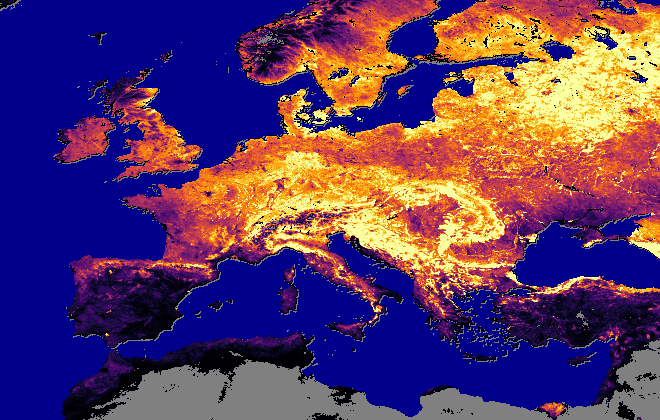

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 
 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0
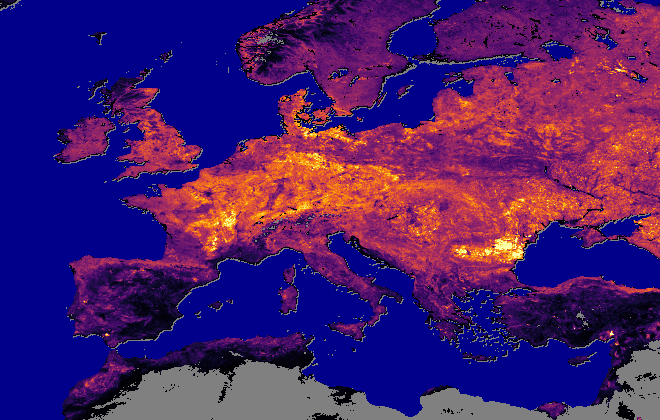

In [14]:
display(plotMAP(v1,dmin=0,dmax=10))
display(plotMAP(v2,dmin=0,dmax=1))

In [15]:
mv1=reduceCube(mean, v1, (LonAxis,LatAxis), skipnull=true);
mv2=reduceCube(mean, v2, (LonAxis,LatAxis), skipnull=true);
println("Mean variance with seasonal cycle: ", mv1.data[1])
println("Mean variance without seasonal cycle: ", mv2.data[1])

Mean variance with seasonal cycle: 5.095334
Mean variance without seasonal cycle: 0.33516657
